In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from typing import List, Dict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, accuracy_score, auc, roc_curve
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 4000
RANDOM_SEED=9509


In [2]:
import nest_asyncio
nest_asyncio.apply()
import stan

In [3]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:0.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

In [4]:
# Data Source: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers
# *NOTE: To fetch data, please run ~/get_data.sh script
df = pd.read_csv("data/BankChurners.csv")

# Data

## Data Exploration

In [5]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [6]:
# Drop variables that are not required
df.drop(
    [
        "CLIENTNUM",
        "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
        "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2",
        "Card_Category"
    ],
    axis=1,
    inplace=True,
)


In [7]:
# Non-null data, balanced data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Months_on_book            10127 non-null  int64  
 8   Total_Relationship_Count  10127 non-null  int64  
 9   Months_Inactive_12_mon    10127 non-null  int64  
 10  Contacts_Count_12_mon     10127 non-null  int64  
 11  Credit_Limit              10127 non-null  float64
 12  Total_Revolving_Bal       10127 non-null  int64  
 13  Avg_Open_To_Buy           10127 non-null  float64
 14  Total_

In [8]:
df.describe(include="all")

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127,10127.000000,10127,10127.000000,10127,10127,10127,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
unique,2,NaN,2,NaN,7,4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Existing Customer,NaN,F,NaN,Graduate,Married,Less than $40K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8500,NaN,5358,NaN,3128,4687,3561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,46.325960,NaN,2.346203,NaN,NaN,NaN,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,NaN,8.016814,NaN,1.298908,NaN,NaN,NaN,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,NaN,26.000000,NaN,0.000000,NaN,NaN,NaN,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,NaN,41.000000,NaN,1.000000,NaN,NaN,NaN,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,NaN,46.000000,NaN,2.000000,NaN,NaN,NaN,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,NaN,52.000000,NaN,3.000000,NaN,NaN,NaN,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000


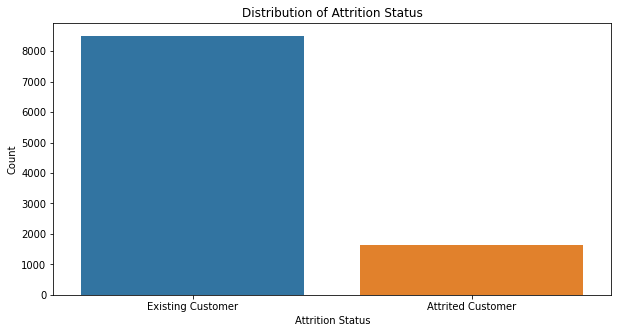

In [9]:
# Target Variable
m = df["Attrition_Flag"].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ["Attrition Status", "Count"]
plt.subplots(figsize=(10, 5))
sns.barplot(y="Count", x="Attrition Status", data=m)
plt.xlabel("Attrition Status")
plt.ylabel("Count")
plt.title("Distribution of Attrition Status")
plt.show()


## Data Pre-processing

### Convert target variable to binary variable

In [10]:
# Convert Categorical Variables to Numerical (1 == Bad credit)
def attrition_status(status):
    if status == "Existing Customer":
        return 0
    else:
        return 1
df["Attrition_Flag"] = df["Attrition_Flag"].apply(attrition_status)
df["Attrition_Flag"].value_counts()

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

### Encoding of categorical variables (OneHotEncoding / LabelEncoding)

As there are categorical values within the dataset, encoding of categorical variables is required. For non-hierarchial variables, dummification is required (e.g, Marital status, Gender and Card category), whereas Label encoding is recommended for variables with rank ordering relationship (e.g., Income level and Education level)

In [11]:
# Separating categorical and non-categorical features
cat_features = [
    col for col in df.columns
    if (df[col].dtype == "object") & (col != "Attrition_Flag")
]
num_features = [
    col for col in df.columns
    if (df[col].dtype != "object") & (col != "Attrition_Flag")
]

In [12]:
# Prepare dataframes
df_y = df["Attrition_Flag"]
df_x = df.loc[:, num_features].astype("float32")

#### OneHot Encoding

In [13]:
# Features with hierarchial structure, label encoding suits better
le_features = ["Income_Category", "Education_Level"]

# Features with non-hierarchial structure, dummification (OneHotEncoding) suits better
oe_features = [i for i in cat_features if i not in le_features]

print(f"OneHot Encoding Features: {oe_features}")
print(f"Label Encoding Features: {le_features}")

onehot_encoders = {}
for col in oe_features:
    oe = OneHotEncoder(handle_unknown='ignore', drop="first")
    onehot_encoders[col] = oe
    df_onehot = pd.DataFrame(oe.fit_transform(df[[col]]).toarray())
    df_onehot.columns = oe.get_feature_names_out()
    df_x = pd.concat([df_x, df_onehot], axis=1)

OneHot Encoding Features: ['Gender', 'Marital_Status']
Label Encoding Features: ['Income_Category', 'Education_Level']


#### Label Encoding

In [14]:
def education_encoder(status):
    if status == "Unknown":
        return 0
    elif status == "Uneducated":
        return 1
    elif status == "High School":
        return 2
    elif status == "College":
        return 3
    elif status == "Graduate":
        return 4
    elif status == "Post-Graduate":
        return 5
    elif status == "Doctorate":
        return 6


def income_category(status):
    if status == "Unknown":
        return 0
    elif status == "Less than $40K":
        return 1
    elif status == "$40K - $60K":
        return 2
    elif status == "$60K - $80K":
        return 3
    elif status == "$80K - $120K":
        return 4
    elif status == "$120K +":
        return 5


In [15]:
df_x["Income_Category"] = df["Income_Category"].apply(income_category)
df_x["Education_Level"] = df["Education_Level"].apply(education_encoder)

In [16]:
df_x = df_x[["Total_Trans_Ct", "Total_Trans_Amt", "Credit_Limit", "Income_Category", "Education_Level", "Gender_M"]]

### Split train / test dataset

In [17]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=9509)

In [64]:
scaler = StandardScaler()
scaler.fit(df_x)
scaled_x_train = x_train.copy()
scaled_x_train[:] = scaler.transform(x_train)
scaled_train_data = pd.concat([scaled_x_train, y_train], axis=1)

scaled_x_test = x_test.copy()
scaled_x_test[:] = scaler.transform(x_test)
scaled_test_data = pd.concat([scaled_x_test, y_test], axis=1)

In [66]:
data1 = dict(
    N=scaled_x_train.shape[0],
    K=scaled_x_train.shape[1],
    X=scaled_x_train.values,
    y=y_train.values,
    p_alpha_df=7,
    p_alpha_loc=0,
    p_alpha_scale=2.5,
    p_beta_df=7,
    p_beta_loc=0,
    p_beta_scale=2.5
)


# Model Methodology

## Logistic Regression

### Non-informative priors (Normal Distribution)

In [67]:
with open("logistic_normal.stan") as r:
    stan_code = r.read()

In [68]:
posterior = stan.build(stan_code, data=data1, random_seed=RANDOM_SEED)
sample = posterior.sample()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/9h/c59t0pfs31x6z7y5j0gplr140000gn/T/httpstan_exy9e_jo/model_3gghh4l3.stan', line 5, column 0: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   1% (101/8000)
Sampling:   1% (102/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  

In [69]:
df_stan_samples = pd.DataFrame(sample["alpha"], index=["alpha"]).T
_df_stan_samples = pd.DataFrame(
    sample["beta"], index=[f"beta_{i}" for i in range(sample["beta"].shape[0])]
).T

df_stan_samples = pd.concat([df_stan_samples, _df_stan_samples], axis=1)

In [70]:
df_stan_samples.mean()

alpha    -2.281165
beta_0   -2.388419
beta_1    1.452773
beta_2    0.020594
beta_3    0.079487
beta_4    0.032212
beta_5   -0.397288
dtype: float64

/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


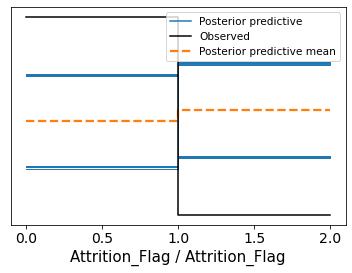

In [170]:
posterior_predictive = normal_logit.predict(normal_logit_result, kind="pps", data=x_test)
az.plot_ppc(normal_logit_result);

accuracy =  0.186


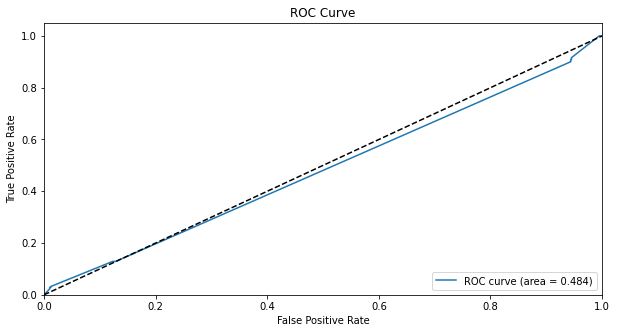

In [171]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
y_pred = (
    normal_logit_result["posterior_predictive"]["Attrition_Flag"].values.mean(axis=0).mean(axis=0)
)
y_test_pred = (y_pred >= 0.5).astype("int")

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")
plot_roc_curve(y_test, y_pred)

### Laplace priors (Sparse solutions)

#### Data Standardisation

In [172]:
scaler = StandardScaler()
scaler.fit(df_x)
scaled_x_train = x_train.copy()
scaled_x_train[:] = scaler.transform(x_train)
scaled_train_data = pd.concat([scaled_x_train, y_train], axis=1)

scaled_x_test = x_test.copy()
scaled_x_test[:] = scaler.transform(x_test)
scaled_test_data = pd.concat([scaled_x_test, y_test], axis=1)

In [173]:
scaled_train_data.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category,Education_Level,Attrition_Flag
4883,-0.664382,-0.266547,-0.867567,1.407306,0.651940,1.396424,2.177523,0.116800,2.166595,-0.401197,0.128619,0.645096,-0.471375,-0.837548,1.059956,-0.928214,1.252337,-0.282609,1.298204,-0.354022,0
5202,0.957290,-0.266547,0.885496,1.407306,0.651940,-0.411616,-0.314464,0.437066,-0.353582,-1.377492,0.011750,0.219045,-0.189951,-0.043143,1.059956,1.077338,-0.798507,-0.282609,1.298204,-1.530263,0
5066,-0.290150,1.273283,-0.491911,1.407306,0.651940,1.396424,-0.791527,-1.218256,-0.682143,0.588785,-0.552578,-0.846080,-1.286247,-0.569119,-0.943436,-0.928214,1.252337,-0.282609,-0.736292,-0.942142,1
8366,0.333570,1.273283,-0.742348,-1.809512,0.651940,0.492404,-0.676357,0.595359,-0.729589,-0.752480,-0.057724,0.261650,0.868542,1.407826,-0.943436,-0.928214,-0.798507,-0.282609,-0.058127,0.822218,0
5012,-0.290150,-0.266547,0.134183,-0.522785,-1.327136,0.492404,-0.733573,-0.174016,-0.717818,-1.112889,-0.128375,-0.334820,0.288891,0.889105,1.059956,-0.928214,-0.798507,3.538459,1.298204,0.822218,0


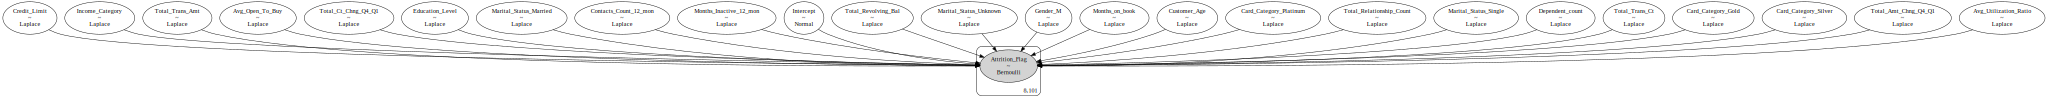

In [117]:
laplace_prior = bambi.Prior("Laplace", mu=0, b=0.05)
laplace_logit = bambi.Model(
    formula,
    scaled_train_data,
    priors=set_priors(normal_prior, laplace_prior, regressors),
    family="bernoulli",
)
laplace_logit.build()
laplace_logit.graph()

In [118]:
laplace_logit_result = laplace_logit.fit(init="adapt_diag", random_seed=RANDOM_SEED)

Modeling the probability that Attrition_Flag==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Education_Level, Income_Category, Card_Category_Silver, Card_Category_Platinum, Card_Category_Gold, Marital_Status_Unknown, Marital_Status_Single, Marital_Status_Married, Gender_M, Avg_Utilization_Ratio, Total_Ct_Chng_Q4_Q1, Total_Trans_Ct, Total_Trans_Amt, Total_Amt_Chng_Q4_Q1, Avg_Open_To_Buy, Total_Revolving_Bal, Credit_Limit, Contacts_Count_12_mon, Months_Inactive_12_mon, Total_Relationship_Count, Months_on_book, Dependent_count, Customer_Age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


In [119]:
az.summary(laplace_logit_result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.836,0.060,-2.955,-2.728,0.001,0.001,2796.0,2919.0,1.00
Customer_Age,-0.013,0.035,-0.084,0.052,0.001,0.001,3452.0,2431.0,1.00
Dependent_count,0.150,0.041,0.073,0.227,0.001,0.000,3604.0,2918.0,1.00
Months_on_book,-0.006,0.035,-0.079,0.058,0.001,0.001,3548.0,2648.0,1.00
Total_Relationship_Count,-0.655,0.046,-0.741,-0.572,0.001,0.001,4020.0,2727.0,1.00
Months_Inactive_12_mon,0.468,0.041,0.397,0.549,0.001,0.000,3732.0,2894.0,1.00
Contacts_Count_12_mon,0.513,0.044,0.426,0.590,0.001,0.000,4471.0,2847.0,1.00
Credit_Limit,-0.013,0.047,-0.111,0.072,0.001,0.001,2769.0,2091.0,1.00
Total_Revolving_Bal,-0.697,0.052,-0.787,-0.592,0.001,0.001,2985.0,2673.0,1.00
Avg_Open_To_Buy,-0.005,0.047,-0.097,0.088,0.001,0.001,3287.0,2045.0,1.00


In [120]:
feature_importance = az.summary(laplace_logit_result)[["mean"]]

In [121]:
# Feature importance by magnitude of coefficients
(abs(feature_importance) / abs(feature_importance.sum())).sort_values(by="mean", ascending=False)

,mean
Intercept,0.540912
Total_Trans_Ct,0.469197
Total_Trans_Amt,0.260729
Total_Revolving_Bal,0.132939
Total_Ct_Chng_Q4_Q1,0.130460
Total_Relationship_Count,0.124928
Contacts_Count_12_mon,0.097845
Months_Inactive_12_mon,0.089262
Gender_M,0.062178
Marital_Status_Married,0.039863


/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


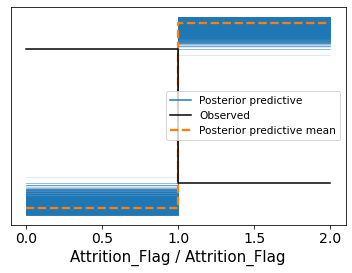

In [122]:
laplace_posterior_predictive = laplace_logit.predict(laplace_logit_result, kind="pps", data=x_test)
az.plot_ppc(laplace_logit_result);

accuracy =  0.164


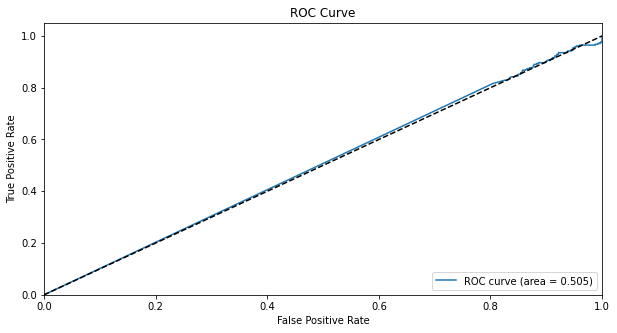

In [123]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
y_pred = (
    laplace_logit_result["posterior_predictive"]["Attrition_Flag"].values.mean(axis=0).mean(axis=0)
)
y_test_pred = (y_pred >= 0.5).astype("int")

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")
plot_roc_curve(y_test, y_pred)

/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


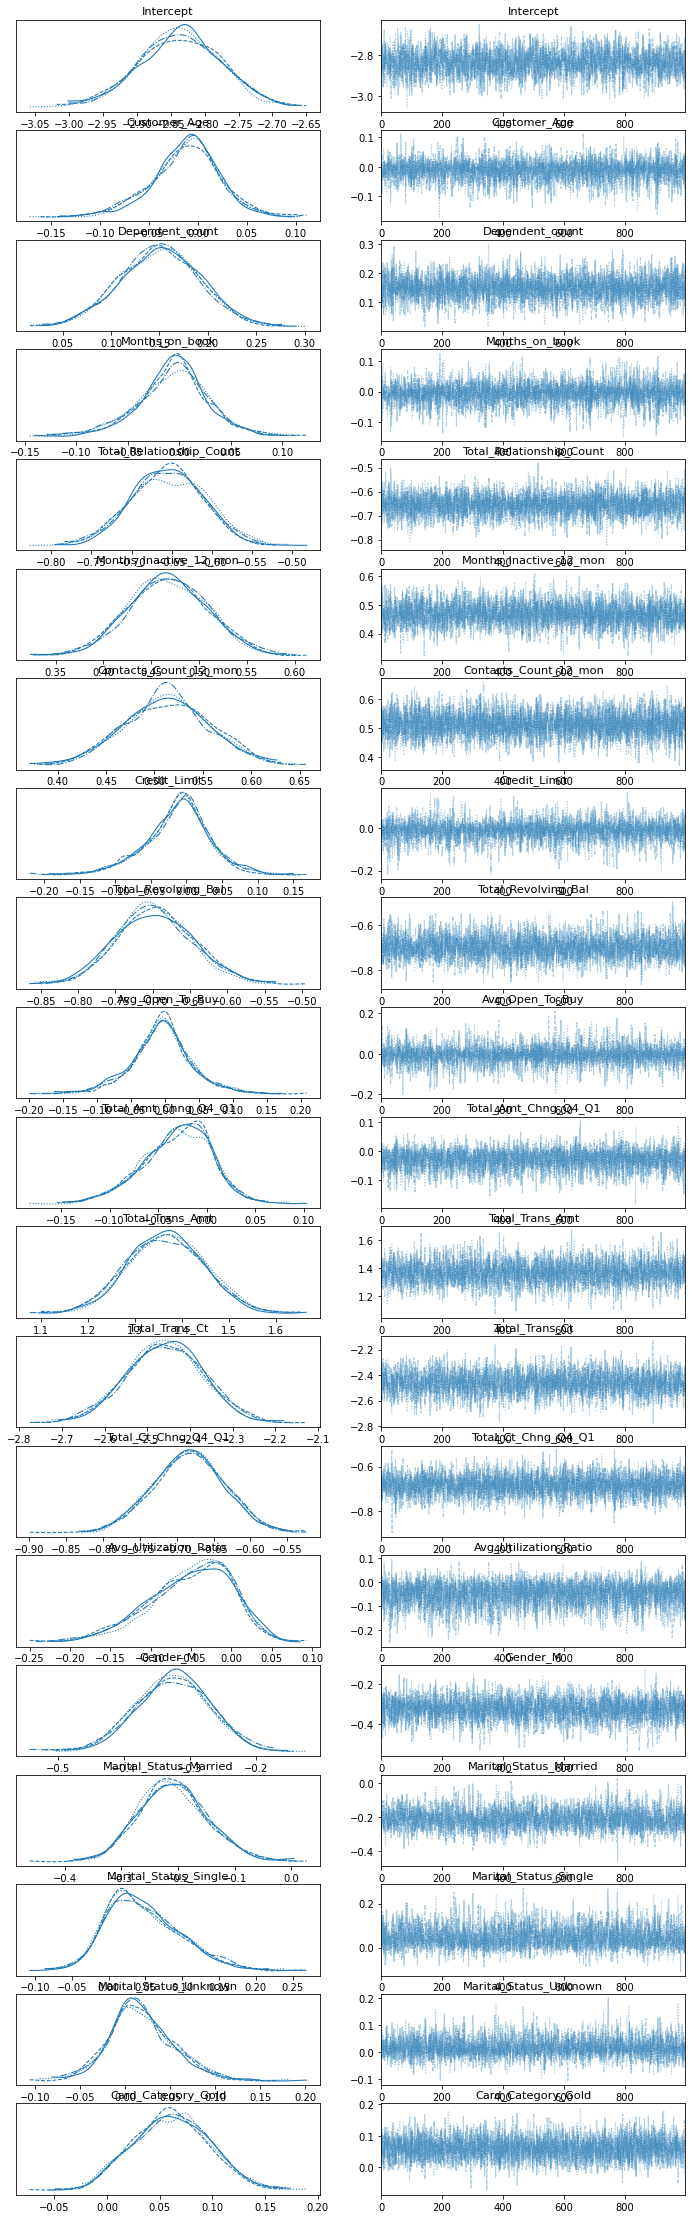

In [124]:
az.plot_trace(data=laplace_logit_result);

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Customer_Age'}>,
        <AxesSubplot:title={'center':'Dependent_count'}>,
        <AxesSubplot:title={'center':'Months_on_book'}>],
       [<AxesSubplot:title={'center':'Total_Relationship_Count'}>,
        <AxesSubplot:title={'center':'Months_Inactive_12_mon'}>,
        <AxesSubplot:title={'center':'Contacts_Count_12_mon'}>,
        <AxesSubplot:title={'center':'Credit_Limit'}>],
       [<AxesSubplot:title={'center':'Total_Revolving_Bal'}>,
        <AxesSubplot:title={'center':'Avg_Open_To_Buy'}>,
        <AxesSubplot:title={'center':'Total_Amt_Chng_Q4_Q1'}>,
        <AxesSubplot:title={'center':'Total_Trans_Amt'}>],
       [<AxesSubplot:title={'center':'Total_Trans_Ct'}>,
        <AxesSubplot:title={'center':'Total_Ct_Chng_Q4_Q1'}>,
        <AxesSubplot:title={'center':'Avg_Utilization_Ratio'}>,
        <AxesSubplot:title={'center':'Gender_M'}>],
       [<AxesSubplot:title={'center':'Marital_St

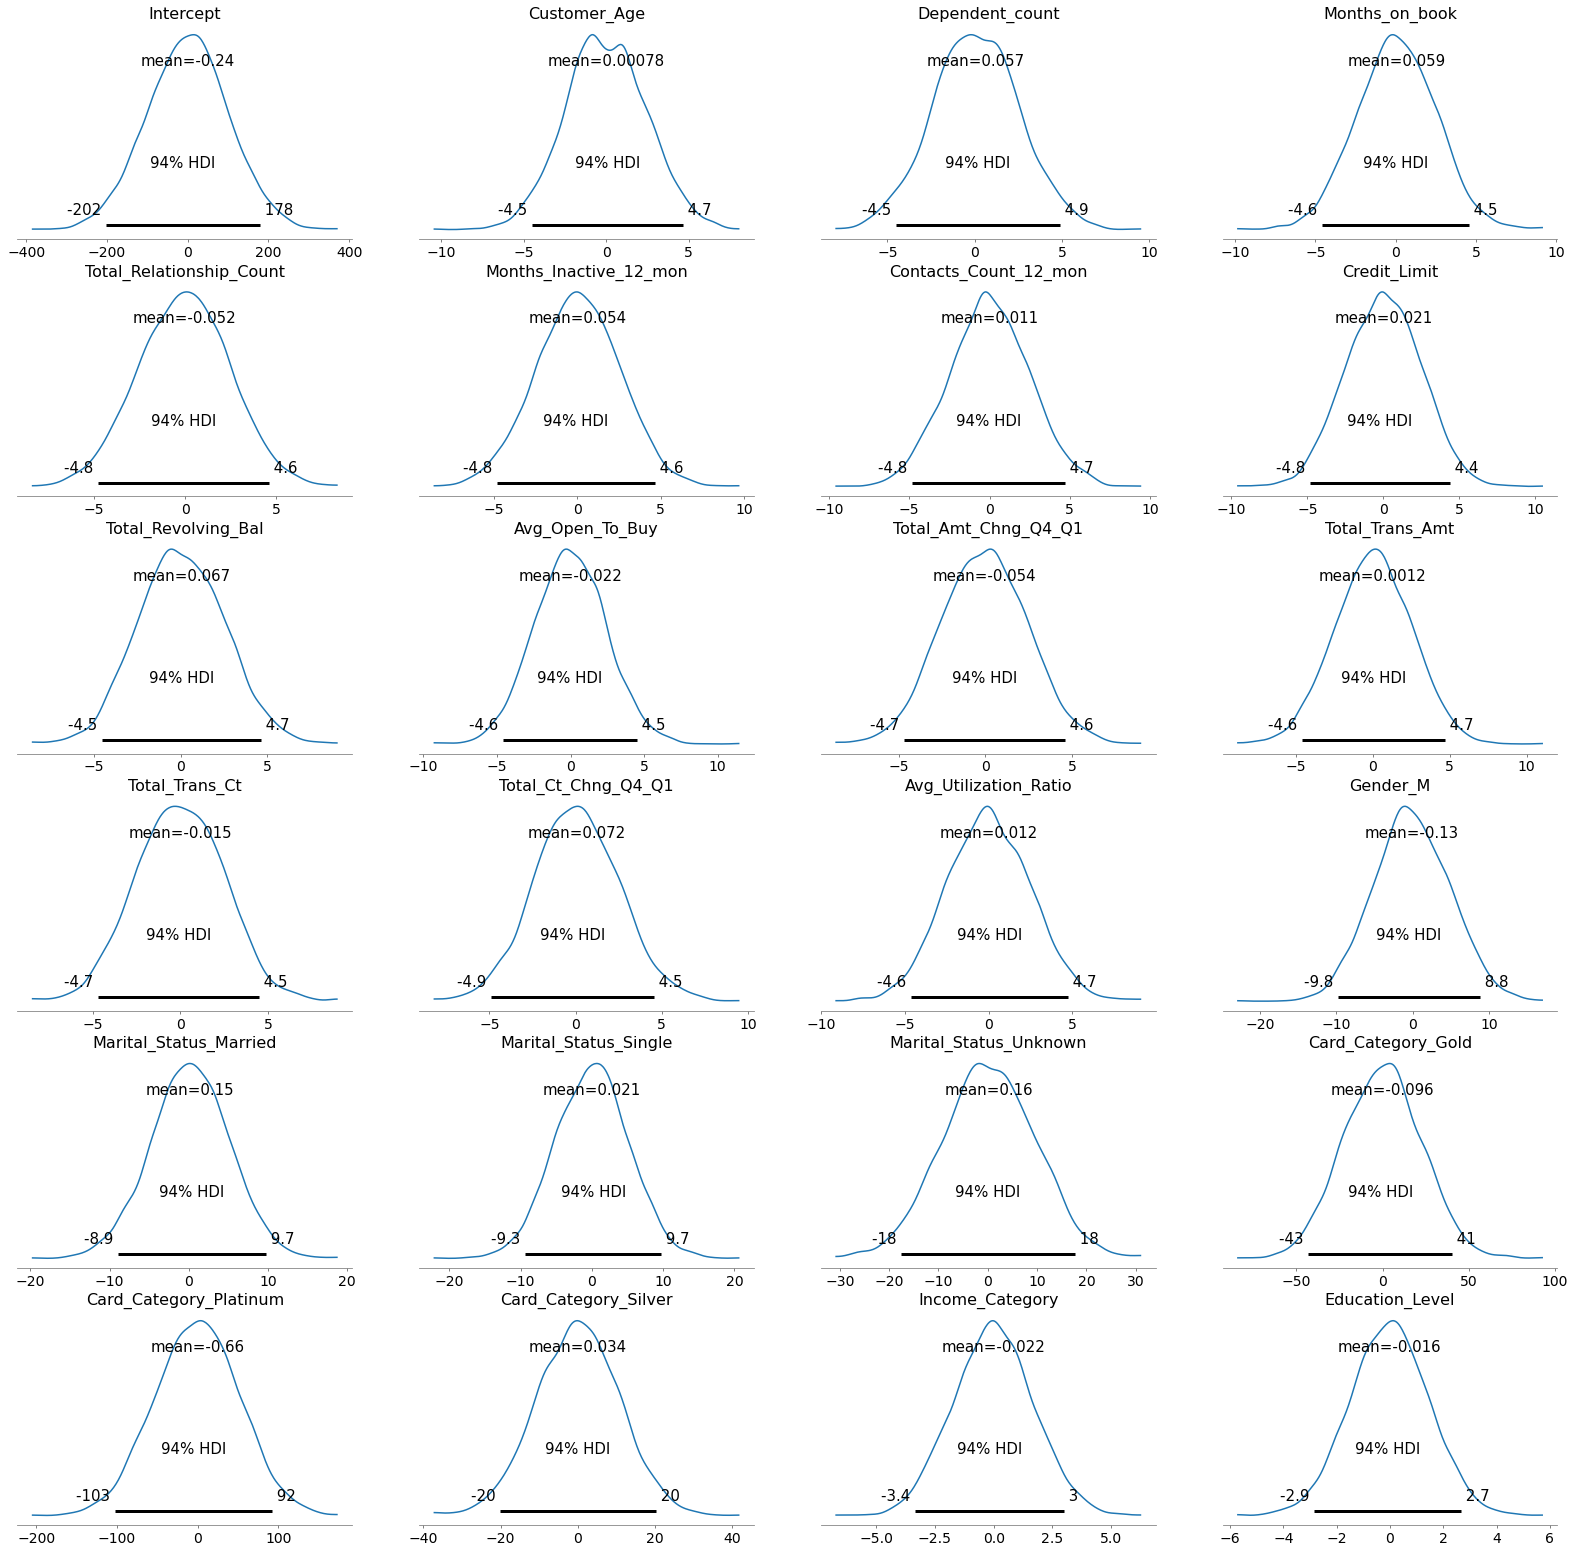

In [318]:
model.plot_priors()

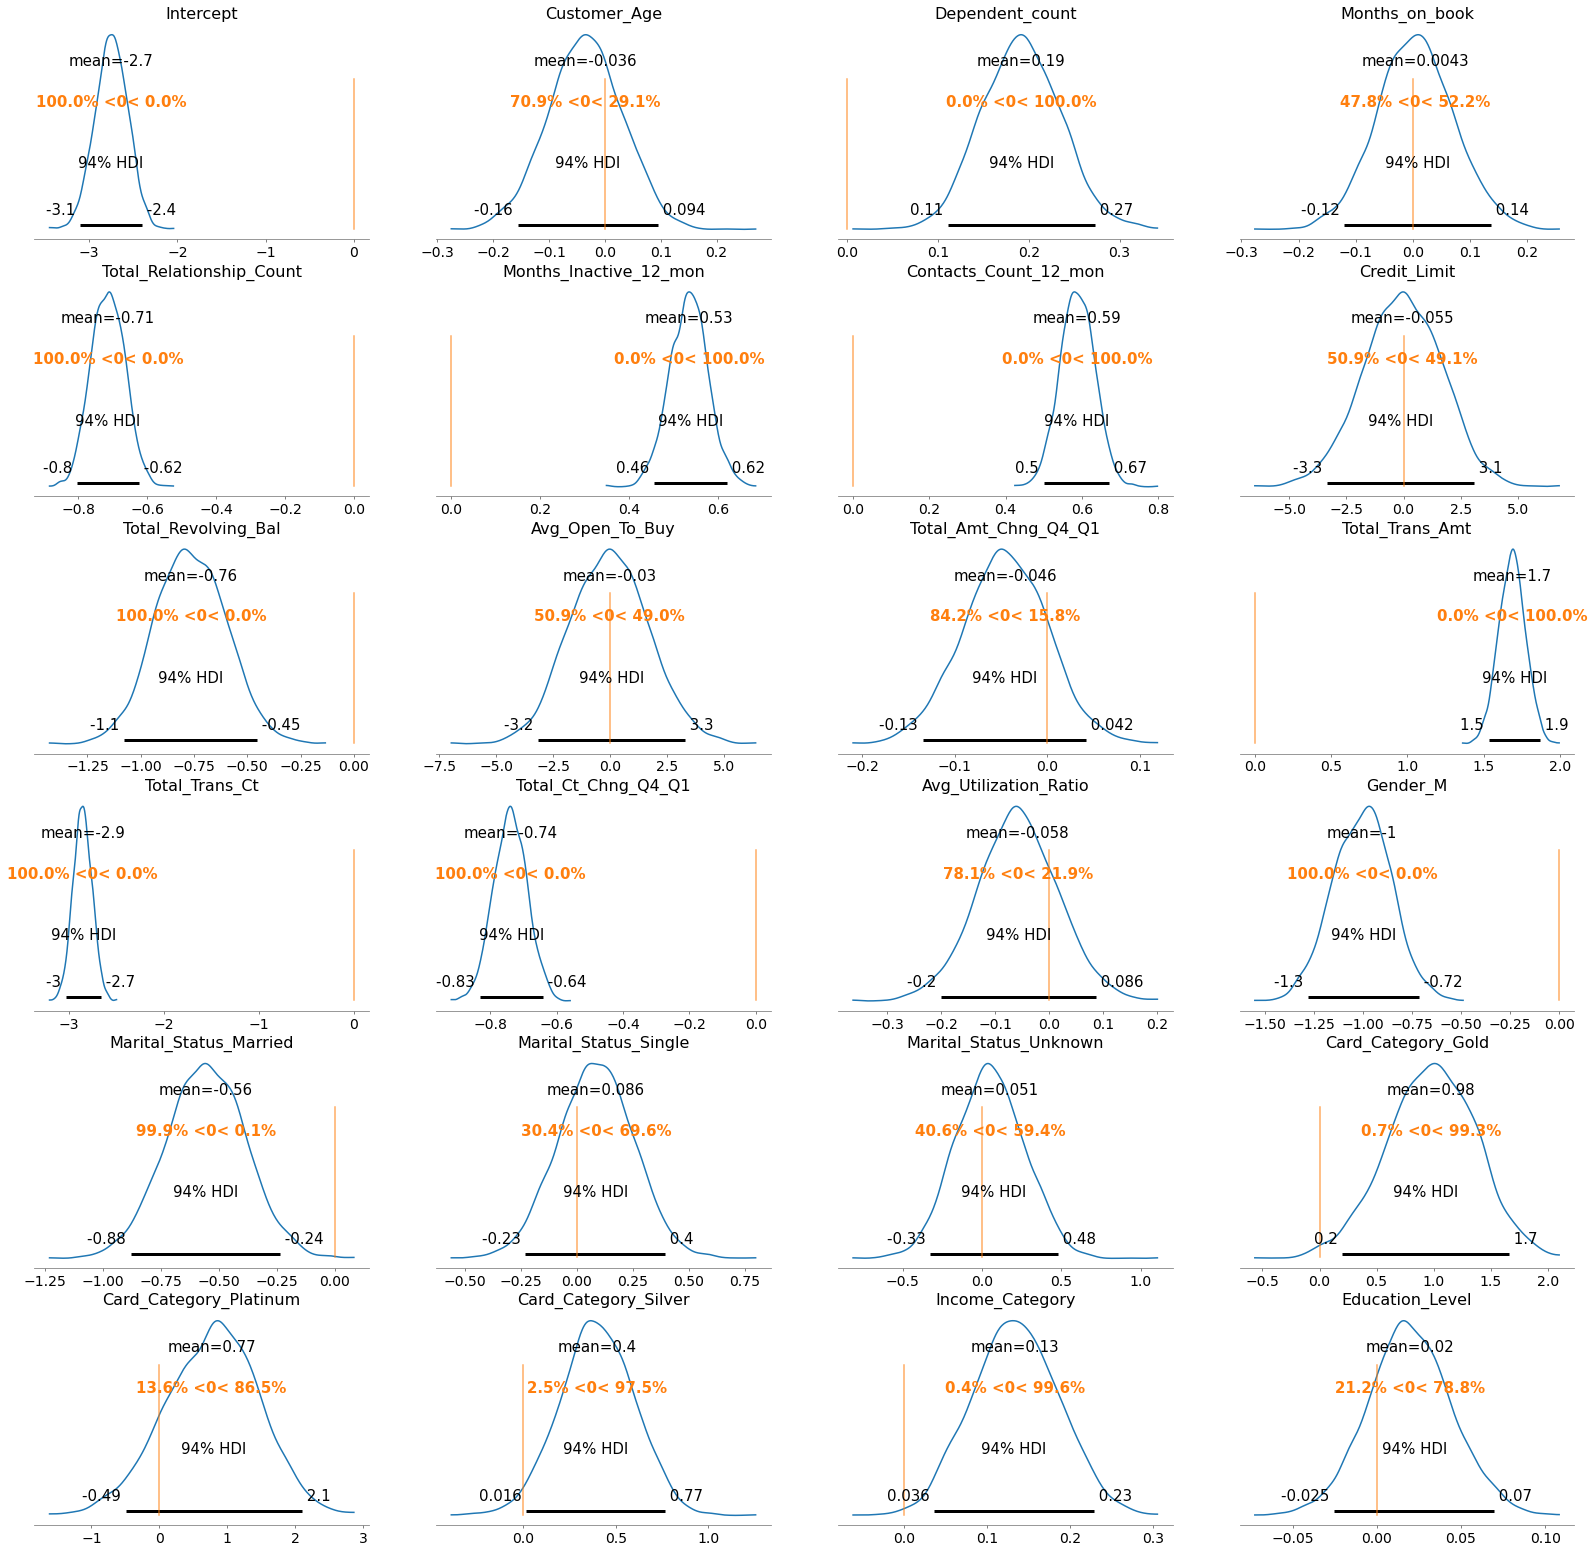

In [319]:
az.plot_posterior(trace, ref_val=0);

Suppose we believe — prior to seeing the data — that α, 𝛽1, and 𝛽2 are probably close to zero, are as likely to be positive as they are to be negative, but have a small chance of being quite far from zero. These beliefs can be represented by Student t distributions with a few degrees of freedom in order to produce moderately heavy tails.

In [130]:
t_prior = bambi.Prior("StudentT", nu=7, mu=0, sigma=2.5)

t_logit = bambi.Model(
    formula,
    scaled_train_data,
    priors=set_priors(t_prior, t_prior, regressors),
    family="bernoulli",
)
t_logit.build()

In [133]:
t_logit_result = t_logit.fit()

Modeling the probability that Attrition_Flag==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Education_Level, Income_Category, Card_Category_Silver, Card_Category_Platinum, Card_Category_Gold, Marital_Status_Unknown, Marital_Status_Single, Marital_Status_Married, Gender_M, Avg_Utilization_Ratio, Total_Ct_Chng_Q4_Q1, Total_Trans_Ct, Total_Trans_Amt, Total_Amt_Chng_Q4_Q1, Avg_Open_To_Buy, Total_Revolving_Bal, Credit_Limit, Contacts_Count_12_mon, Months_Inactive_12_mon, Total_Relationship_Count, Months_on_book, Dependent_count, Customer_Age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 376 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8793467404176887, but should be close to 0.8. Try to increase the number of tuning steps.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.


In [134]:
az.summary(t_logit_result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.070,0.071,-3.200,-2.936,0.002,0.001,1639.0,2491.0,1.0
Customer_Age,-0.034,0.070,-0.170,0.094,0.002,0.001,2164.0,1780.0,1.0
Dependent_count,0.193,0.042,0.115,0.273,0.001,0.001,3644.0,2259.0,1.0
Months_on_book,0.002,0.070,-0.134,0.130,0.001,0.001,2425.0,1891.0,1.0
Total_Relationship_Count,-0.714,0.048,-0.800,-0.620,0.001,0.001,3789.0,2622.0,1.0
Months_Inactive_12_mon,0.534,0.045,0.450,0.617,0.001,0.001,2808.0,1990.0,1.0
Contacts_Count_12_mon,0.587,0.046,0.504,0.674,0.001,0.001,3233.0,2190.0,1.0
Credit_Limit,-0.069,1.844,-3.506,3.387,0.059,0.041,1006.0,1222.0,1.0
Total_Revolving_Bal,-0.761,0.178,-1.082,-0.437,0.006,0.004,1044.0,1180.0,1.0
Avg_Open_To_Buy,-0.017,1.845,-3.470,3.403,0.059,0.042,1005.0,1318.0,1.0


## LDA

In [ ]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sd=10, shape=2)
    σ = pm.HalfNormal('σ', 10)
    setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_0[:50]) 
    versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ, observed=x_0[50:])
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(1000)


In [29]:
clf = LinearDiscriminantAnalysis(solver='lsqr',store_covariance=True)
clf.fit(x_train, y_train)

LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)

Accuracy Score 0.8968410661401777


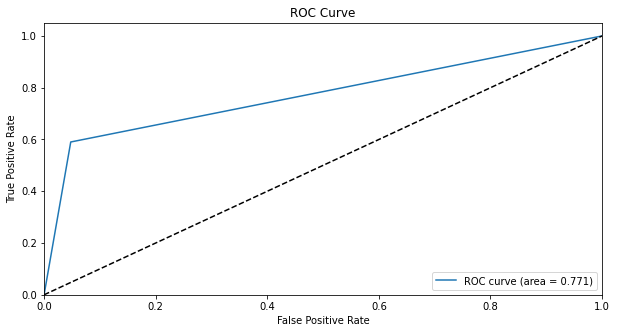

In [30]:
pred_lda = clf.predict(x_test)
print(f"Accuracy Score {accuracy_score(y_true=y_test, y_pred=pred_lda)}")
plot_roc_curve(y_test, pred_lda)

# QDA

Accuracy Score 0.8983218163869694


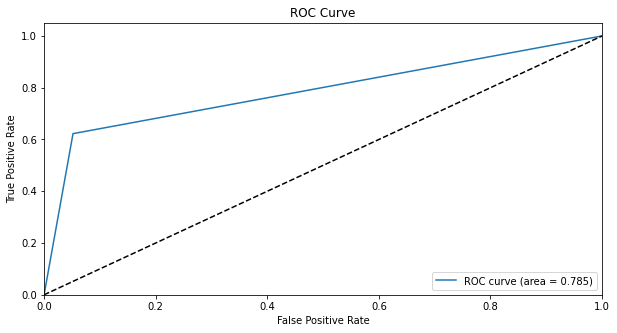

In [31]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(x_train, y_train)

pred_qda = clf.predict(x_test)
print(f"Accuracy Score {accuracy_score(y_true=y_test, y_pred=pred_qda)}")
plot_roc_curve(y_test, pred_qda)